# Data Loading

In [3]:
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional
from pathlib import Path
from experiments.evaluation.utils import recover_traincfg_from_wandb

sys.path.append("../..")

folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-22/12-33-40",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-22/15-12-06",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-23/09-19-32"
]
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-01-05/16-26-14"
]


env_name = "CARLPendulumEnv"
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-04-05/14-31-22",
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-04-05/14-30-21",
]

env_name = "CARLDmcWalkerEnv"
folders_eval = [
    "/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58",
    "/home/eimer/Dokumente/git/CARL/multirun/2023-04-20/10-43-59",
    "/home/eimer/Dokumente/git/CARL/multirun/2023-04-20/10-45-51",
]


replacements_bounds = {
    "[0.9, 1.1]": 0.1,
    "[0.75, 1.25]": 0.25,
    "[0.5, 1.5]": 0.5,
    "[1, 2.2]": 2.2,
    "[1, 2.5]": 2.5,
}
key_interval = "$\Delta_{rel}$"
key_visibility = "visibility"
key_performance = "return"
key_cf = "context_sampler.context_feature_names"

match env_name:
    case "CARLPendulumEnv":
        context_feature = "['l']"
    case "CARLDmcWalkerEnv":
        context_feature = "['viscosity']"
    case _:
        raise ValueError


from rich import print as printr
from rich.progress import track
import pickle
from pathlib import Path
import numpy as np
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths


def load_wandb_table(fn: Union[str, Path]) -> pd.DataFrame:
    data = lazy_json_load(fn)
    data = pd.DataFrame(data=np.array(data["data"]), columns=data["columns"])
    return data


reload_rpc: bool = True

fn_config = ".hydra/config.yaml"
fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
fn_wbconfig = "wandb/latest-run/files/config.yaml"

dfs = []
lost_paths = []
for folder_eval in folders_eval:
    printr(f"Loading from {folder_eval}")
    rpc_fn = Path("rpc" + Path(folder_eval).name + ".csv")
    if not rpc_fn.is_file():
        reload_rpc = True

    paths = find_multirun_paths(result_dir=folder_eval)

    if reload_rpc:
        rpc_list = []
        for i, p in tqdm(enumerate(paths), total=len(paths)):
            p = Path(p)
            fn_cfg = p / fn_config
            fn_wbsum = p / fn_wbsummary
            fn_wbcfg = p / fn_wbconfig
            if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
                continue
            cfg = OmegaConf.load(fn_cfg)
            traincfg = recover_traincfg_from_wandb(fn_wbcfg)
            summary = lazy_json_load(fn_wbsum)

            if "average_return" in summary:
                average_return = summary["average_return"]
            else:
                average_return = None

            if average_return is None:
                lost_paths.append(p)
                continue

            entry = {
                "average_return": average_return,
            }

            path_to_table = fn_wbsum.parent / summary["return_per_context_table"]["path"]
            return_per_context = load_wandb_table(path_to_table)

            # Sort by context id so we can add repetition info
            return_per_context.sort_values(by="context_id", inplace=True)
            n_contexts = return_per_context["context_id"].nunique()
            n_reps = len(return_per_context) // n_contexts
            assert n_contexts * n_reps == len(return_per_context)
            repetitions = np.concatenate([np.arange(0, n_reps)] * n_contexts)
            return_per_context["rep"] = repetitions

            contexts_path = fn_wbsum.parent / summary["evalpost/contexts"]["path"]
            contexts = load_wandb_table(contexts_path)

            visibility = traincfg.wandb.group

            context_ids = return_per_context["context_id"].apply(int).to_list()
            contexts_to_table = pd.DataFrame([contexts.iloc[cidx] for cidx in context_ids])
            for col in contexts_to_table.columns:
                return_per_context[col] = contexts_to_table[col].to_numpy()
            n = len(return_per_context)
            # return_per_context["average_return"] = [average_return] * n
            return_per_context[key_visibility] = visibility
            return_per_context[key_interval] = replacements_bounds[str(traincfg.context_sampler.uniform_bounds_rel)]
            return_per_context["context_sampler.context_feature_names"] = str(traincfg.context_sampler.context_feature_names)
            return_per_context["seed"] = traincfg.seed
            return_per_context["algorithm"] = traincfg.algorithm
            rpc_list.append(return_per_context)

            # if i == 10:
            #     break

    if reload_rpc:
        if len(rpc_list) == 0:
            printr("Folder is empty")
            continue
        df_rpc = pd.concat(rpc_list)
        df_rpc.to_csv(rpc_fn)
    else:
        df_rpc = pd.read_csv(rpc_fn)
    dfs.append(df_rpc)

df_rpc = pd.concat(dfs).reset_index(drop=True)
df_rpc.sort_values(by=key_visibility, inplace=True)

printr("Lost paths")
printr(lost_paths)

Loading from /home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58

100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


Loading from /home/eimer/Dokumente/git/CARL/multirun/2023-04-20/10-43-59

100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Loading from /home/eimer/Dokumente/git/CARL/multirun/2023-04-20/10-45-51

100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


Lost paths

[
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/0'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/1'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/5'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/6'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/10'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/11'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/15'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/16'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/19'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/20'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/21'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/22'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/24'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/25'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/26'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/27'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/28'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/29'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/30'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/31'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/32'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/33'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/34'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/35'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/36'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/37'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/38'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/39'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/40'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/41'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/42'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/43'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/44'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/45'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/46'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/47'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/48'),
    PosixPath('/home/eimer/Dokumente/git/CARL/multirun/2023-03-01/10-21-58/49')
]

In [4]:
print(df_rpc.columns)
print(df_rpc["context_sampler.context_feature_names"].unique())
print(df_rpc["visibility"].unique())

Index(['context_id', 'return', 'rep', 'actuator_strength', 'density',
       'friction_rolling', 'friction_tangential', 'friction_torsional',
       'geom_density', 'gravity', 'joint_damping', 'joint_stiffness',
       'timestep', 'viscosity', 'wind_x', 'wind_y', 'wind_z', 'visibility',
       '$\Delta_{rel}$', 'context_sampler.context_feature_names', 'seed',
       'algorithm'],
      dtype='object')
["['viscosity']"]
['concat (all)' 'concat (non-static)' 'hidden']


In [5]:
df_rpc = df_rpc[df_rpc["context_sampler.context_feature_names"] == context_feature]
df_rpc = df_rpc[df_rpc["visibility"].isin(["concat (all)", "concat (non-static)", "hidden"])]

# Boxplots

Index(['context_id', 'return', 'rep', 'actuator_strength', 'density',
       'friction_rolling', 'friction_tangential', 'friction_torsional',
       'geom_density', 'gravity', 'joint_damping', 'joint_stiffness',
       'timestep', 'viscosity', 'wind_x', 'wind_y', 'wind_z', 'visibility',
       '$\Delta_{rel}$', 'context_sampler.context_feature_names', 'seed',
       'algorithm', 'dt', 'g', 'initial_angle_max', 'initial_velocity_max',
       'l', 'm', 'max_speed'],
      dtype='object')

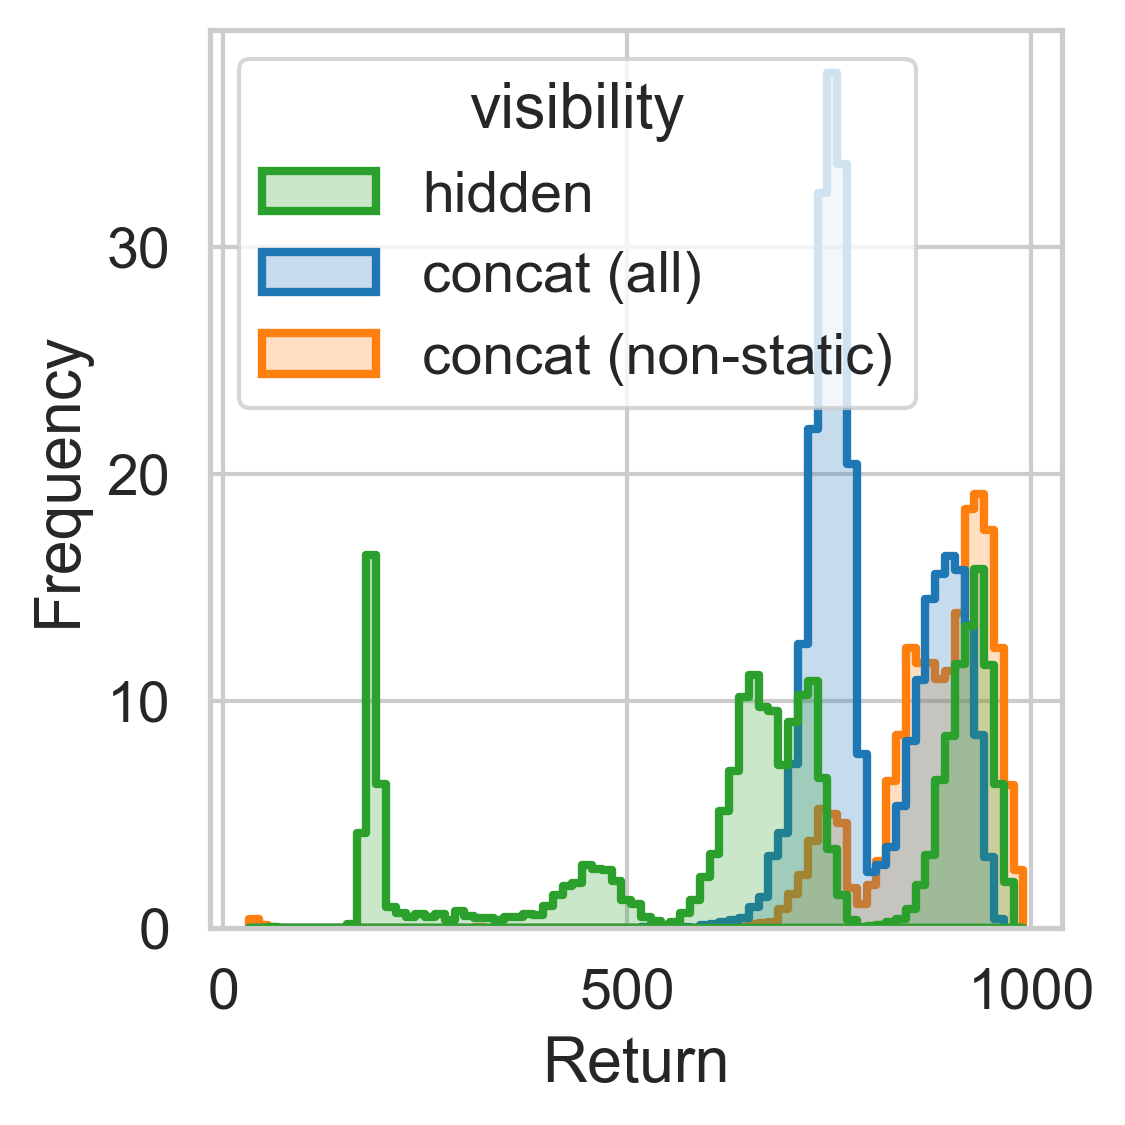

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pathlib import Path


sns.set_palette("colorblind")
# sns.set_palette("tab10")
sns.set(font_scale=1.25)
sns.set_style("whitegrid")

printr(df_rpc.columns)
key = key_visibility
data = df_rpc

# All data points
hue = key_visibility
x = key_interval
y = key_performance


title = "No Aggregation"
title = None

hue_order = ["hidden", "concat (all)", "concat (non-static)"]
pal = sns.color_palette("tab10", n_colors=3)
ids = [2, 0, 1]
palette = {k: pal[v] for k, v in zip(hue_order, ids)}

fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x=y, hue=hue, stat="frequency", multiple="layer", element="step", hue_order=hue_order, palette=palette, ax=ax, lw=2)
ax.set_title(title)
ax.set_xlabel("Return")
# ax.set_xticks([-1500, -1000, -500, 0])
sns.move_legend(ax, "upper left")
# ax.get_legend()(loc="upper left")
fig.set_tight_layout(True)
fig_fn = Path(f"data/figures/benchmarking_test/test_{env_name}.pdf")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()


Index(['context_id', 'return', 'rep', 'actuator_strength', 'density',
       'friction_rolling', 'friction_tangential', 'friction_torsional',
       'geom_density', 'gravity', 'joint_damping', 'joint_stiffness',
       'timestep', 'viscosity', 'wind_x', 'wind_y', 'wind_z', 'visibility',
       '$\Delta_{rel}$', 'context_sampler.context_feature_names', 'seed',
       'algorithm'],
      dtype='object')

(
    array(['concat (all)', 'concat (non-static)', 'hidden'], dtype=object),
    array([10000,  8000,  9000])
)

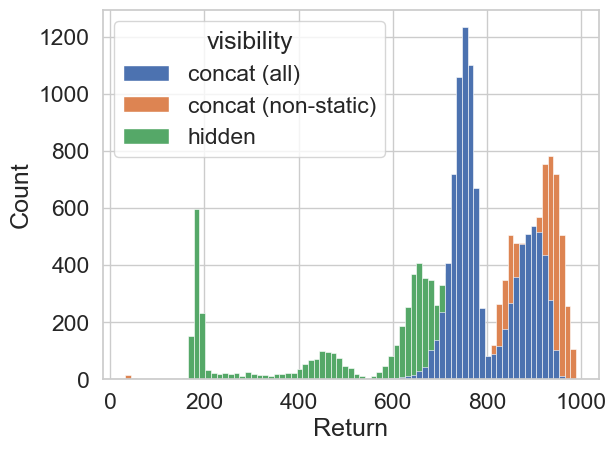

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


sns.set_palette("colorblind")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

printr(df_rpc.columns)
key = key_visibility
data = df_rpc  # df_rpc[(df_rpc[key] == "hidden") | (df_rpc[key] == "cgate_hadamard") | (df_rpc[key] == "concat (non-static)")]
# data = data[data["context_sampler.context_feature_names"] == "['l']"]
# data = data[data["context_sampler.context_feature_names"] == "['m', 'l', 'g', 'dt', 'max_speed']"]
# data = data[data[key_interval] == 0.5]
printr(np.unique(data[key_visibility], return_counts=True))

data["step"] = 1

# All data points
hue = key_visibility
x = key_interval
y = key_performance


title = "No Aggregation"
title = None

fig = plt.Figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x=y, hue=hue, alpha=1)
ax.set_title(title)
ax.set_xlabel("Return")
fig.set_tight_layout(True)
plt.show()

#########################
# grid = sns.FacetGrid(data=data, row=key_cf, legend_out=True)
# grid.map_dataframe(sns.kdeplot, x=y, hue=hue)
# grid.add_legend()
# plt.show()

# grid = sns.FacetGrid(data=data, row=key_cf, col=key_interval, legend_out=True,)
# grid.map_dataframe(sns.kdeplot, x=key_performance, hue=hue, )
# grid.add_legend()
# plt.show()

# grid = sns.FacetGrid(data=data, row=key_cf, col=key_interval, legend_out=True,)
# grid.map_dataframe(sns.boxplot, x="step", y=key_performance, hue=hue, )
# grid.add_legend()
# plt.show()

# ax = sns.boxplot(data=data, x=hue, y=y, hue=None)
# ax.legend()
# ax.set_title(title)
# plt.show()

# ax = sns.boxplot(data=data, x=x, y=y, hue=hue)
# ax.legend()
# ax.set_title(title)
# plt.show()

# ax = sns.violinplot(data=data, x=x, y=y, hue=hue, multiple="dodge", cut=0)
# ax.legend()
# ax.set_title(title)
# plt.show()

##################################
# # Averaging first
# title = "Aggregated by Mean per Seed"

# reduced = data.groupby([key_visibility, key_interval, "seed"])[key_performance].mean(numeric_only=True)
# # reduced = data.groupby([key_visibility, key_interval, "seed"])[key_performance].apply(scipy.stats.trim_mean, proportiontocut=0.25, axis=None)
# reduced = reduced.reset_index()  # multi-index (groups) back to normal columns
# df = reduced

# ax = sns.boxplot(data=df, x=hue, y=y, hue=None)
# ax.legend()
# ax.set_title(title)
# plt.show()

# ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
# ax.legend()
# ax.set_title(title)
# plt.show()

# ax = sns.violinplot(data=df, x=x, y=y, hue=hue, multiple="dodge", cut=0)
# ax.legend()
# ax.set_title(title)
# plt.show()



# title = "Aggregated by IQM per Seed"

# reduced = data.groupby([key_visibility, key_interval, "seed"])[key_performance].apply(scipy.stats.trim_mean, proportiontocut=0.25, axis=None)
# reduced = reduced.reset_index()  # multi-index (groups) back to normal columns
# df = reduced

# ax = sns.boxplot(data=df, x=hue, y=y, hue=None)
# ax.legend()
# ax.set_title(title)
# plt.show()

# ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
# ax.legend()
# ax.set_title(title)
# plt.show()

# ax = sns.violinplot(data=df, x=x, y=y, hue=hue, multiple="dodge", cut=0)
# ax.legend()
# ax.set_title(title)
# plt.show()



# IQM

In [8]:
from rliable import library as rly
from rliable import metrics
import importlib
import rliable.plot_utils
importlib.reload(rliable.plot_utils)

fig_fn = "tmp/figures/iqm.png"

data = df_rpc

if "algorithm" in data:
  del data["algorithm"]

reps = 10000
xlabel = ""

metric_names = ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  # metrics.aggregate_optimality_gap(x)
  ])


keep_cfs = ["[]", "[m]", "[g]", "[l]", "[dt]"]
filter_visibilities = ["concat (all)", "cgate_lstm"]


# Create score matrix
# Scores: (num_points x num_tasks), here:
#         (num_seeds * num_reps x num_tasks)
# Pendulum: num_tasks = n_contexts = 128


# Create score matrix
# Scores: (num_points x num_tasks), here:
# here:
#     num_points = n_contexts * n_seeds * n_reps
#     n_tasks = n_intervals * n_cfs
score_dict = {}
tasks = [key_interval, "context_sampler.context_feature_names"]
points = ["seed", "rep", "context_id"]
for group_id, group_df in data.groupby("visibility"):
  # Determine size of score matrix
  def count(x):
    counts = group_df[x].nunique()
    # print(x, counts)
    return counts
  n_points = np.prod([count(x) for x in points])
  n_tasks = np.prod([count(x) for x in tasks])
  scores = np.zeros((n_points, n_tasks))
  print(scores.shape)
  for i, ((seed, rep, context_id), gdf) in enumerate(group_df.groupby(["seed", "rep", "context_id"])):
    
    # gdf.sort_values(by="context_id", inplace=True)
    n = len(gdf)
    if n > n_tasks:
      print(f"Warning! We have more tasks than specified. {n} > {n_tasks}. Capping.")
      new_df = []
      for sid, sdf in gdf.groupby(tasks):
        # printr(sid, len(sdf), sdf)
        new_df.append(sdf.iloc[np.random.choice(np.arange(0, len(sdf)))])
      gdf = pd.DataFrame(new_df) #.reset_index(drop=True)
      del gdf["Unnamed: 0"]
    elif n < n_tasks:
      print(f"Warning! We have less tasks than specified. {n} > {n_tasks}. Skip.", seed, rep, context_id)
      continue
      # printr(gdf)

    # print(n, seed, rep,)
    # print(gdf[key_interval].nunique(), gdf["context_sampler.context_feature_names"].nunique())
    gdf.sort_values(by="context_sampler.context_feature_names", inplace=True)
    # printr(gdf)
    # index = (seed - 1) * n_seeds + rep  # seed is 1-based
    R = gdf["return"]
    scores[i] = R
  score_dict[group_id] = scores




        


(10000, 1)
(10000, 1)
(10000, 1)


Calculate interval estimates

Plot interval estimates

(5, 4.5)


FileNotFoundError: [Errno 2] No such file or directory: 'tmp/figures/iqm.png'

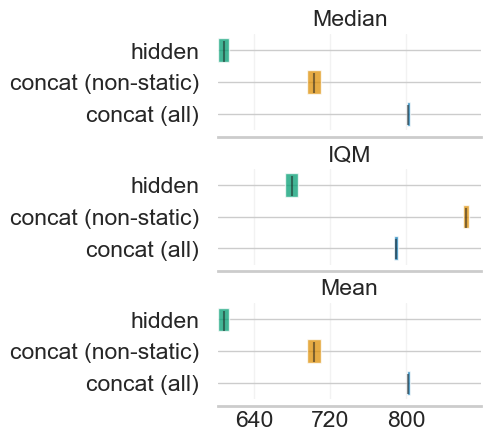

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=0.8)
sns.set_style("whitegrid")

# filter_visibilities = ["concat (all)", "cgate_lstm"]
# for vis in filter_visibilities:
#     if vis in score_dict:
#         del score_dict[vis]

printr("Calculate interval estimates")
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)

printr("Plot interval estimates")
fig, axes = rliable.plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=metric_names,
    algorithms=list(score_dict.keys()), xlabel=xlabel,
    asrows=True,
    row_height=0.5,
    interval_height=0.75
)
fig.set_tight_layout(True)
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()


24